Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

# Vaja 9: Sledenje in analiza gibanja

## Navodila
Na podlagi zaporedja slik zajetih z eno ali več kamerami lahko analiziramo gibanje objektov v 3D prostoru in s to informacijo načrtujemo povratno-zančno vodenje, manipulacijo, sledenje ter izvajamo rekonstrukcijo in detekcijo teh objektov. Postopek analize gibanja običajno sestavlja več osnovnih postopkov, npr. postopek za robustno zaznavanje objektov zanimanja, iskanje korespondenc med zaporedno zajetimi slikami in poravnava slik. Pri vaji boste načrtali postopek sledenja objekta zanimanja oz. *tarče* z uporabo **Lucas-Kanade poravnave slik**. 

Pri tem postopku za sledenje uporabljamo parametrični model preslikave $\mathcal{T} : \mathbb{R}^2 \rightarrow \mathbb{R}^2$ med zaporedno zajetima 2D slikama $I_k(\mathbf{x})$ in $I_{k-1}(\mathbf{x})$ ($\mathbf{x} = [x, y]^{\mathrm{T}}$), kjer je prva slika zajeta ob času $t(k)$, druga pa ob $t(k-1)$ in pri čemer je $t(k) > t(k-1)$. Parametrični model $\mathcal{T}(\mathbf{x}; \mathbf{p})$ je npr. translacija, podobnostna, afina ali projektivna preslikava ($\mathbf{p}$ ima 2, 3, 6 oz. 8 parametrov). Privzamemo, da se med dvema zaporednima slikama $I_1$ in $I_2$ ohranja svetlost slikovnih elementov $I_1(\mathbf{x}) = I_2(\mathcal{T}(\mathbf{x}; \mathbf{p})) + n(\mathbf{x})$, kjer je $n(\mathbf{x}) \sim \mathcal{N}(0,\sigma^2)$ Gaussov šum. Za mero podobnosti uporabimo vsoto kvadradov razlik med slikama. Ker pričakujemo majhne premike tarče med slikama $I_1$ in $I_2$ ($\mathbf{p} \rightarrow 0$) lahko iščemo le optimalen korak $\Delta\mathbf{p}^{\star}$ v parametrih preslikave

$$
\Delta\mathbf{p}^{\star} = \underset{\Delta\mathbf{p}}{\arg\min} \sum_{\mathbf{x}} \left[ I_2(\mathcal{T}(\mathbf{x}; \mathbf{p}+\Delta\mathbf{p})) - I_1(\mathbf{x})\right]^2
$$

parametre preslikave pa dobimo kot $\mathbf{p} \leftarrow \mathbf{p} + \Delta\mathbf{p}^{\star}$. Optimalni korak $\Delta\mathbf{p}^{\star}$ izračunamo brez optimizacije tako, da izraz $I_2(\mathcal{T}(\mathbf{x}; \mathbf{p}+\Delta\mathbf{p}))$ aproksimiramo s Taylorjevo vrsto kot 

$$
I_2(\mathcal{T}(\mathbf{x}; \mathbf{p}+\Delta\mathbf{p})) \approx
I_2(\mathcal{T}(\mathbf{x}; \mathbf{p})) + \nabla I_2(\mathcal{T}(\mathbf{x}; \mathbf{p})) \frac{\partial\mathcal{T}}{\partial\mathbf{p}} \Delta\mathbf{p}
$$

kjer je $\nabla I_2(\mathcal{T}(\mathbf{x}; \mathbf{p})) = [I_x, I_y]$ gradient slike $I_2$ ($\scriptstyle{\nabla I_2 = \left[\frac{\partial I_2}{\partial x}, \frac{\partial I_2}{\partial x}\right] = [I_x, I_y]}$) pri trenutni preslikavi $\mathcal{T}(\mathbf{x}; \mathbf{p})$. Izraz $\partial\mathcal{T} / \partial\mathbf{p}$ predstavlja Jacobijevo matriko prvih odvodov in zavisi od izbrane parametrične preslikave $\mathcal{T}$. Razliko med slikama v prvi enačbi lahko zapišemo v matrični obliki kot $\mathbf{I}_t + \mathbf{B} \Delta\mathbf{p}$, kjer je $\mathbf{I}_t = \mathbf{I}_2(\mathcal{T}(\mathbf{p})) - \mathbf{I}_1$; $\mathbf{I}_k$ je $N\times 1$ vektor sivinskih vrednosti slike. Izrazi za $\mathbf{B}$ pri translaciji in afini preslikavi so podani spodaj.

![Enacbe](images/RV_10_SLO_Enacbe.png)

Optimalen korak $\Delta\mathbf{p}^{\star}$ v parametrih preslikave se nato izraža kot
$$
\Delta\mathbf{p}^{\star} = \underset{\Delta\mathbf{p}}{\arg\min} (\mathbf{I}_t + \mathbf{B} \Delta\mathbf{p})^{\mathrm{T}} (\mathbf{I}_t + \mathbf{B} \Delta\mathbf{p})\,,
$$
njegovo vrednost pa dobimo tako, da odvajamo gornjo enačbo na $\Delta\mathbf{p}$ in odvod izenačimo z 0. Dobimo linearen sistem enačb za $\Delta\mathbf{p}^{\star} $, ki ima rešitev
$$
\Delta\mathbf{p}^{\star} = -\left(\mathbf{B}^{\mathrm{T}} \mathbf{B}\right)^{-1} \mathbf{B}^{\mathrm{T}} \mathbf{I}_t\,.
$$
Postopek Lucas-Kanade izvajamo iterativno tako, da zaporedoma izračunavamo optimalen korak $\Delta\mathbf{p}^{\star}$ in posodabljamo parametre preslikave $\mathbf{p}_{i} = \mathbf{p}_{i-1} + \Delta\mathbf{p}^{\star}$ do nekega maksimalnega števila iteracij $i_{\max}$ ali dokler $\|\mathbf{p}_{i} - \mathbf{p}_{i-1}\|<\epsilon$. Potek postopka je prikazan na spodnji sliki.

![Lucas-Kanade](images/RV_10_SLO_LucasKanade.png)

Postopek Lucas-Kanade konvergira v najbližji lokalni minimum, zato je potrebno za pri večjih premikih tarče med slikami uporabiti dober začetni približek parametrov $\mathbf{p}$. Dober začetni približek lahko dobimo z uporabo piramidne decimacije tako, da poravnamo sliki najprej pri redkejšem vzorčenju, parametre pa nato izboljšamo pri gostejšem vzorčenju slike. Gostoto vzorčenja običajno spreminjamo s korakom $\times 2$, glede na spremembo koraka vzorčenja pa enako spreminjamo tudi parametre $\mathbf{p}$.

Sledenje tarči v videu izvedemo tako, da v prvi sliki ročno ali avtomatsko določimo središče tarče $(x_c,y_c)$ in velikost pravokotnega okna $(w,h)$ tako, da okno vsebuje celotno tarčo. Če poznamo središče tarče v sliki $I_1$, potem z Lucas-Kanade postopkom poravnamo sliko $I_1$ na naslednjo zajeto sliko $I_{2}$ in glede na dobljeno preslikavo $\mathcal{T}(\mathbf{x};\mathbf{p})$ posodobimo središče tarče v sliki $I_{2}$. Postopek ponavljamo za vse naslednje zaporedne pare zajetih slik $\{I_k, I_{k+1}\}, k = 1,\ldots,T-1$.

## Naloge
**Gradivo** za vajo vsebuje videa `video1.avi` in `video2.avi` zajeta z nadzorno kamero s pogledom na pločnik iz ptičje perspektive. V Python skripti `funkcije.py` so pripravljene funkcije, ki jih boste potrebovali za izvedbo vaje, pri kateri boste načrtali postopek za sledenje gibanja oseb, ki se sprehajajo po pločniku.

Poleg gradiva boste za nalaganje videov v Python boste potrebovali knjižnico `ffmpeg`, ki jo najdete na spletnem naslovu https://www.ffmpeg.org/download.html. Program `ffmpeg.exe` skopirajte v vašo delovno mapo.

1. Orodje `ffmpeg.exe` naložite v delovno mapo, nato pa okvirje v video datoteki `data/video1.avi` naložite v Python spremenljivko `numpy.array` s pomočjo funkcije `loadVideo()` in prikažite s funkcijo `ipywidgets.interact()` kot prikazuje naslednja skripta:

Berem okvir 178 ... koncano!



<IPython.core.display.Javascript object>


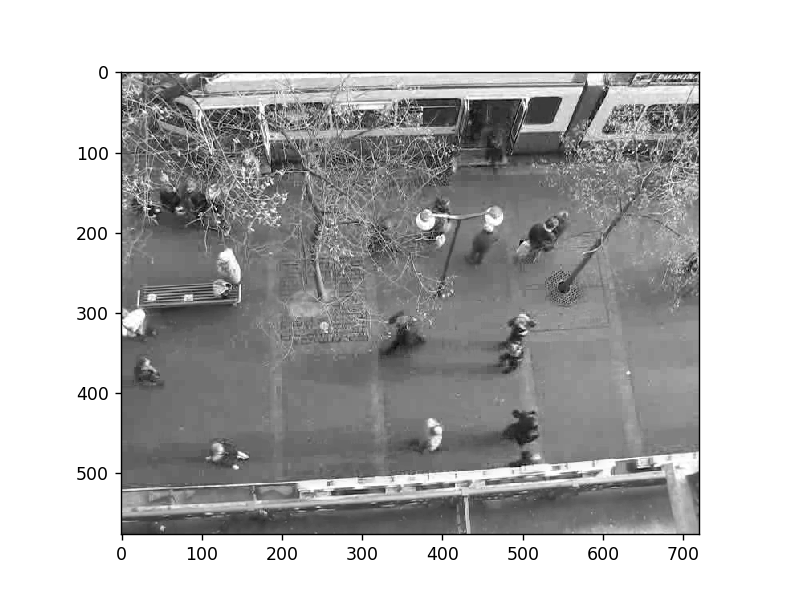

interactive(children=(IntSlider(value=0, description='frame', max=176), Output()), _dom_classes=('widget-inter…

<function __main__.update>

In [10]:
# nalozi knjiznico
from ipywidgets import interact, IntSlider
%matplotlib notebook
from funkcije import *
# nalozi video
oVideo = loadVideo('data/video1.avi')

# prikaz
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(oVideo[...,0], cmap='gray')

def update(frame):
    img.set_data(oVideo[...,frame])
    fig.canvas.draw()

interact(update, frame = IntSlider(min=0, max=oVideo.shape[2] - 1))

2. Napišite funkcijo za poravnavo dveh sivinskih slik `iImgFix` in `iImgMov` z Lucas-Kanade postopkom:
```python
    def regLucasKanade( iImgFix, iImgMov, iMaxIter ):
        return oPar, oImgReg
```
 kjer je `iImgMov` premična slika, ki jo želimo poravnati na fiksno sliko `iImgFix`. Parameter `iMaxIter` predstavlja število korakov Lucas-Kanade postopka. Funkcija vrne dvovrstični vektor parametrov `oPar` s translacijama $\mathbf{p} = [t_x, t_y]^{\mathrm{T}}$ in preslikano premično sliko v spremenljivki `oImgReg`. Vhodni sliki `iImgFix` in `iImgMov` in izhodna slika `oImgReg` imajo enake dimenzije.

 Preizkusite delovanje poravnave na prvi sliki v videu `video1.avi` tako, da sliko preslikate s parametri $\mathbf{p} = [-5, 3]^{\mathrm{T}}$ in nato poravnate z Lucas-Kanade postopkom. Ocenjeni parametri preslikave `oPar` morajo biti približno enaki dejanskim parametrom $\mathbf{p}$.

In [11]:
def regLucasKanade(iImgFix, iImgMov, iMaxIter, oPar = (0,0), iVerbose=True):
    """Postopek poravnave Lucas-Kanade"""
    # pretvori vhodne slike v numpy polja tipa float
    iImgType = np.asarray(iImgMov).dtype
    iImgFix = np.array(iImgFix, dtype='float')
    iImgMov = np.array(iImgMov, dtype='float')
    # doloci zacetne parametre preslikae
    oPar = np.array(oPar)     
    # izracunaj prva odvoda slike
    Gx, Gy = imageGradient(iImgMov)      
    # v zanki iterativno posodabljaj parametre
    for i in range(iMaxIter):
        # doloci preslikavo pri trenutnih parametrih        
        oMat2D = transAffine2D(iTrans=oPar)        
        # preslikaj premicno sliko in sliki odvodov        
        iImgMov_t = transformImage(iImgMov, oMat2D)
        Gx_t = transformImage(Gx, oMat2D)
        Gy_t = transformImage(Gy, oMat2D)        
        # izracunaj sliko razlike in sistemsko matriko
        I_t = iImgMov_t - iImgFix
        B = np.vstack((Gx_t.flatten(), Gy_t.flatten())).transpose()
        # resi sistem enacb
        invBtB = np.linalg.inv(np.dot(B.transpose(), B))
        dp = np.dot(np.dot(invBtB, B.transpose()), I_t.flatten())        
        # posodobi parametre        
        oPar = oPar + dp.flatten()           
        if iVerbose: print('iter: %d' % i, ', oPar: ', oPar)
    # doloci preslikavo pri koncnih parametrih        
    oMat2D = transAffine2D(iTrans=oPar)        
    # preslikaj premicno sliko        
    oImgReg = transformImage(iImgMov, oMat2D).astype(iImgType)
    # vrni rezultat
    return oPar, oImgReg

iter: 0 , oPar:  [ 0.00060521 -0.13482019]
iter: 1 , oPar:  [ 0.00130148 -0.26820701]
iter: 2 , oPar:  [ 0.00193872 -0.39355774]
iter: 3 , oPar:  [ 0.00243477 -0.50427239]
iter: 4 , oPar:  [ 0.00274711 -0.59676532]
iter: 5 , oPar:  [ 0.00288522 -0.67136554]
iter: 6 , oPar:  [ 0.00288806 -0.73071059]
iter: 7 , oPar:  [ 0.00279858 -0.77792125]
iter: 8 , oPar:  [ 0.00265196 -0.81572259]
iter: 9 , oPar:  [ 0.00247365 -0.84625037]
iter: 10 , oPar:  [ 0.002281   -0.87111761]
iter: 11 , oPar:  [ 0.0020854  -0.89153406]
iter: 12 , oPar:  [ 0.0018941  -0.90841226]
iter: 13 , oPar:  [ 0.00171151 -0.92244818]
iter: 14 , oPar:  [ 0.00154017 -0.93417931]
iter: 15 , oPar:  [ 0.00138134 -0.94402595]
iter: 16 , oPar:  [ 0.00123545 -0.95232064]
iter: 17 , oPar:  [ 0.0011024  -0.95932933]
iter: 18 , oPar:  [ 0.00098172 -0.96526669]
iter: 19 , oPar:  [ 8.72743198e-04 -9.70307505e-01]
parameters:  [ 8.72743198e-04 -9.70307505e-01]
elapsed time:  12273.654999999992  ms


<IPython.core.display.Javascript object>


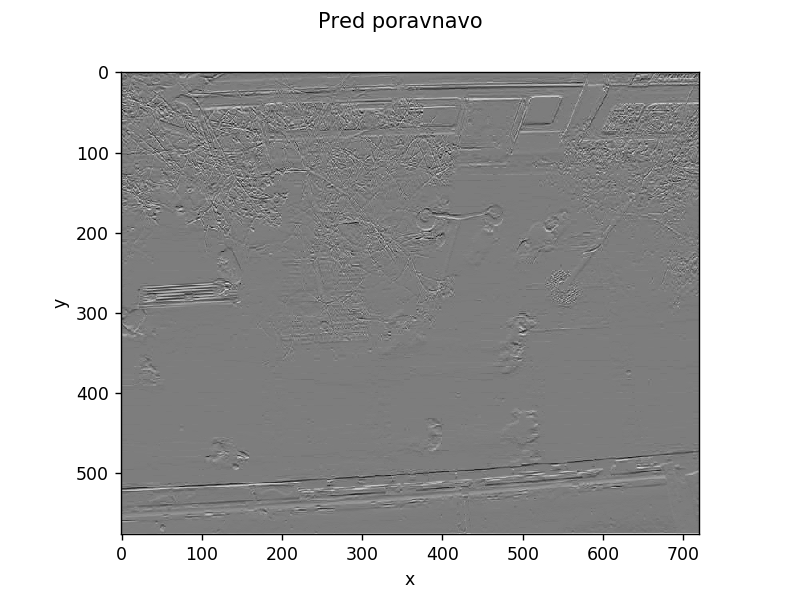

<IPython.core.display.Javascript object>


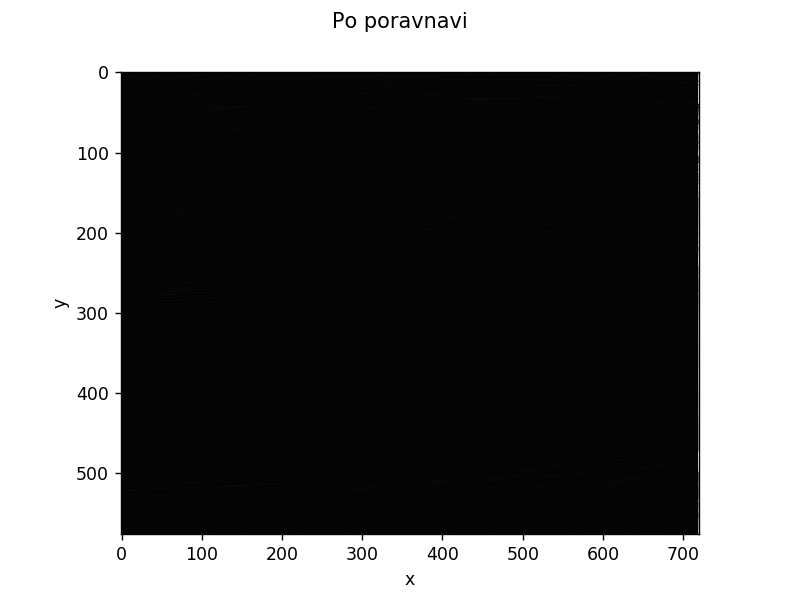

In [15]:
from rvlib import showImage
# Preizkus funkcije regLucasKanade

# doloci fiksno in premicno sliko
oPar = [0, 1]
iImgFix = oVideo[:,:,0]
iImgMov = transformImage(iImgFix, transAffine2D(iTrans = oPar))
# klici Lucas-Kanade poravnavo slik
import time    
ts = time.clock()
oPar, oImgReg = regLucasKanade(iImgFix, iImgMov, 20)
print('parameters: ', oPar)
print('elapsed time: ', 1000.0*(time.clock()-ts), ' ms')  
# narisi rezultate
showImage(iImgFix.astype('float') - iImgMov.astype('float'), 'Pred poravnavo')
showImage(iImgFix.astype('float') - oImgReg.astype('float'), 'Po poravnavi')

3. Napišite funkcijo za poravnavo dveh sivinskih slik `iImgFix` in `iImgMov` s piramidnim Lucas-Kanade postopkom:
```python
    def regPyramidLK( iImgFix, iImgMov, iMaxIter, iNumScales ):
        return oPar, oImgReg
```
 kjer je `iImgMov` premična slika, ki jo želimo poravnati na fiksno sliko `iImgFix`. Vhodni parameter `iNumScales` ($s$) je število zaporednih decimacij vhodnih slik
`iImgMov` in `iImgFix` s korakom 1:2, ki sestavljajo piramido slik s progresivno manjšim vzorčenjem. Lucas-Kanade postopek izvedemo zaporedno na slikah od najmanjšega do največjega vzorčenja, hkrati pa pri prehodu iz enega na drugi nivo posodobimo začetne parametre kot $\mathbf{p}^{s} = 2 \times \mathbf{p}^{s-1}$. Parameter `iMaxIter` predstavlja število korakov Lucas-Kanade postopka v vsakem nivoju piramide.

 Preizkusite delovanje poravnave na prvi sliki v videu `video1.avi` tako, da sliko preslikate s parametri $\mathbf{p} = [50, -30]^{\mathrm{T}}$ in nato poravnate s piramidnim Lucas-Kanade postopkom. Ocenjeni parametri preslikave `oPar` morajo biti približno enaki dejanskim parametrom $\mathbf{p}$.

In [16]:
def regPyramidLK(iImgFix, iImgMov, iMaxIter, iNumScales, iVerbose=True):
    """Piramidna implementacija poravnave Lucas-Kanade"""
    # pretvori vhodne slike v numpy polja tipa float
    iImgFix = np.array(iImgFix, dtype='float')
    iImgMov = np.array(iImgMov, dtype='float')
    # pripravi piramido slik
    iPyramid = [ (iImgFix, iImgMov) ]
    for i in range(1,iNumScales):
        # decimiraj fiksno in premicno sliko za faktor 2
        iImgFix_2 = decimateImage2D(iImgFix, i)
        iImgMov_2 = decimateImage2D(iImgMov, i)
        # dodaj v seznam
        iPyramid.append((iImgFix_2,iImgMov_2))
    # doloci zacetne parametre preslikave
    oPar = np.array((0,0))          
    # izvedi poravnavo od najmanjse do najvecje locljivosti slik
    for i in range(len(iPyramid)-1,-1,-1):
        if iVerbose: 
            print('PORAVNAVA Z DECIMACIJO x{}'.format(2**i))
        # posodobi parametre preslikave
        oPar = oPar * 2.0
        # izvedi poravnavo pri trenutni locljivosti
        oPar, oImgReg = regLucasKanade(iPyramid[i][0], iPyramid[i][1], \
                            iMaxIter, oPar, iVerbose=iVerbose)
    # vrni koncne parametre in poravnano sliko
    return oPar, oImgReg

PORAVNAVA Z DECIMACIJO x4
iter: 0 , oPar:  [-0.00924329 -0.09902857]
iter: 1 , oPar:  [-0.01691135 -0.21276406]
iter: 2 , oPar:  [-0.02318954 -0.34324474]
iter: 3 , oPar:  [-0.0278893  -0.49080215]
iter: 4 , oPar:  [-0.03104544 -0.65143243]
iter: 5 , oPar:  [-0.03301411 -0.81563156]
iter: 6 , oPar:  [-0.03430712 -0.97240153]
iter: 7 , oPar:  [-0.03529238 -1.11526964]
iter: 8 , oPar:  [-0.03415946 -1.26401517]
iter: 9 , oPar:  [-0.0317189  -1.41798476]
iter: 10 , oPar:  [-0.02840367 -1.56914321]
iter: 11 , oPar:  [-0.0248238  -1.70803632]
iter: 12 , oPar:  [-0.02147747 -1.82877336]
iter: 13 , oPar:  [-0.01858375 -1.930862  ]
iter: 14 , oPar:  [-0.01615785 -2.01686829]
iter: 15 , oPar:  [-0.01389371 -2.09211763]
iter: 16 , oPar:  [-0.0116067  -2.16115489]
iter: 17 , oPar:  [-0.00941538 -2.22276274]
iter: 18 , oPar:  [-0.00741026 -2.27625983]
iter: 19 , oPar:  [-0.00564516 -2.32158194]
PORAVNAVA Z DECIMACIJO x2
iter: 0 , oPar:  [-0.00904361 -4.70565498]
iter: 1 , oPar:  [-0.00724932 -4.75

<IPython.core.display.Javascript object>


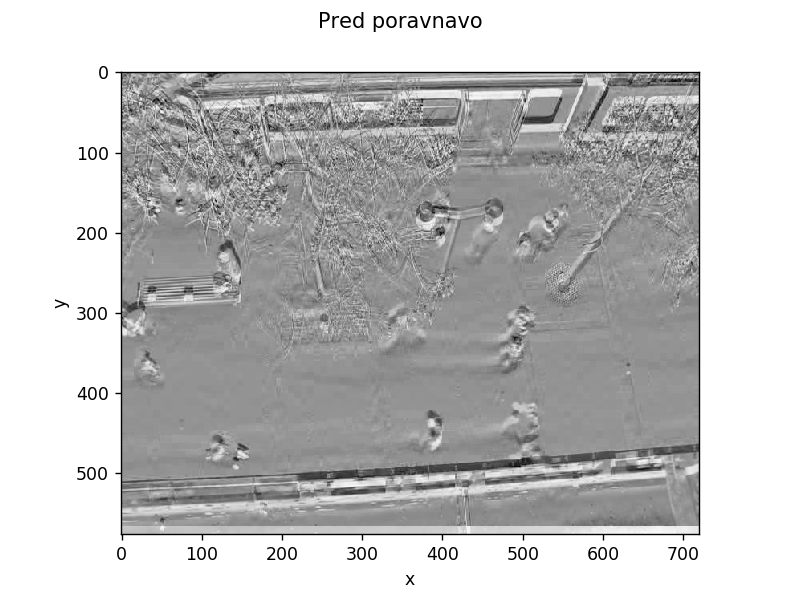

<IPython.core.display.Javascript object>


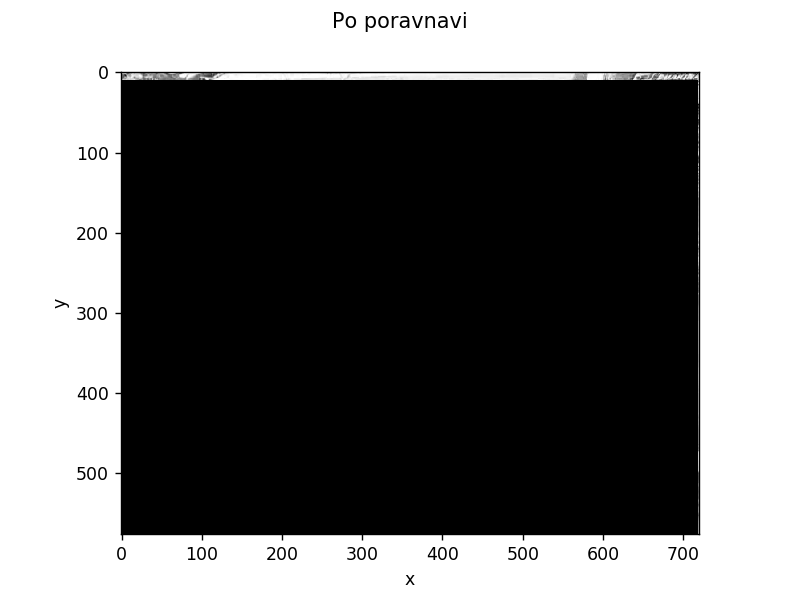

In [17]:
# Preizkus funkcije regPyramidLK
# doloci fiksno in premicno sliko
oPar = [0, 10]
iImgFix = oVideo[:,:,0]
iImgMov = transformImage(iImgFix, transAffine2D(iTrans = oPar))
# klici Lucas-Kanade poravnavo slik
import time    
ts = time.clock()    
oPar, oImgReg = regPyramidLK(iImgFix, iImgMov, 20, 3)
print('parameters: ', oPar)
print('elapsed time: ', 1000.0*(time.clock()-ts), ' ms')  
# narisi rezultate
showImage(iImgFix.astype('float') - iImgMov.astype('float'), 'Pred poravnavo')
showImage(iImgFix.astype('float') - oImgReg.astype('float'), 'Po poravnavi')

4. Napišite funkcijo za sledenje izbrani tarči v videu s piramidnim Lucas-Kanade postopkom: 
```python
    def trackTargetLK( iVideoMat, iCenterXY, iFrameXY ):
        return oPathXY
```
 kjer je `iVideoMat` video v matriki z dimenzijami $X\times Y \times T$; $X, Y$ sta prostorski, $T$ pa časovna os. Vhodna parametra `iCenterXY` in `iFrameXY` sta dvovrstična vektorja, ki ustrezata središču tarče $(x_c, y_c)$ in velikost pravokotnega okna $(w,h)$ tarče. Funkcija vrne sled tarče v matriki `oPathXY` dimenzij $2 \times T$, tj. središče tarče v vsakem  okvirju videa.

 Preizkusite postopek za sledenje tarče na videu `video1.avi`. V prvem okvirju videa ima tarča središče $(x_c, y_c) = [34, 371]^{\mathrm{T}}$ in se nahaja v pravokotnem oknu $(w, h) = [40, 40]^{\mathrm{T}}$. Prikažite video in vrišite sled tarče tako, kot je prikazano na spodnji sliki.

In [19]:
def trackTargetLK(iVideoMat, iCenterXY, iFrameXY, iVerbose=True):
    """Postopek sledenja Lucas-Kanade"""
    # pretvori vhodni video v numpy polje
    iVideoMat = np.asarray(iVideoMat)
    iCenterXY = np.array(iCenterXY)
    # definiraj izhodno spremenljivko
    oPathXY = np.array(iCenterXY.flatten()).reshape((1,2))
    # definiraj koordinate v tarci
    gx, gy = np.meshgrid(range(iFrameXY[0]), range(iFrameXY[1]))
    gx = gx - float(iFrameXY[0]-1)/2.0
    gy = gy - float(iFrameXY[1]-1)/2.0
    # zazeni LK preko vseh zaporednih okvirjev
    for i in range(1,iVideoMat.shape[-1]):
        # vzorcni tarco v dveh zaporednih okvirjih        
        iImgFix = interpolate1Image2D(iVideoMat[...,i-1], \
                    gx+oPathXY[-1,0], gy+oPathXY[-1,1])
        iImgMov = interpolate1Image2D(iVideoMat[...,i], \
                    gx+oPathXY[-1,0], gy+oPathXY[-1,1])
        # zazeni piramidno LK poravnavo
        oPar, oImgReg = regPyramidLK(iImgFix, iImgMov, 30, 3, iVerbose=False)
        # shrani koordinate
        oPathXY = np.vstack((oPathXY, oPathXY[-1,:] + oPar.flatten()))     
        print('\rkoordinate tarce: ', oPathXY[-1,:], end="")
    # vrni spremenljivko
    return oPathXY

In [20]:
# Preizkus funkcije trackTargetLK
# klici Lucas-Kanade sledenje tarci
import time    
ts = time.clock()    
oPathXY = trackTargetLK(oVideo[...,:], (33,370), (40,40))
print('\nelapsed time: ', 1000.0*(time.clock()-ts), ' ms')

koordinate tarce:  [708.68160298 388.3347041 ]
elapsed time:  87114.98  ms


<IPython.core.display.Javascript object>


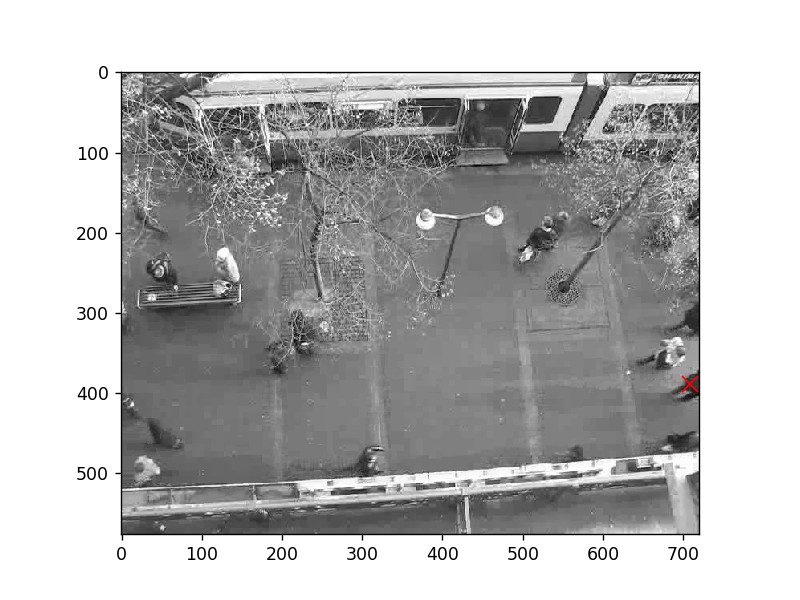

interactive(children=(IntSlider(value=0, description='frame', max=176), Output()), _dom_classes=('widget-inter…

<function __main__.update>

In [21]:
# prikaz
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def update(frame):
    #img.set_data(oVideo[...,frame])
    ax.clear()
    ax.imshow(oVideo[...,frame], cmap='gray')
    ax.plot(oPathXY[frame, 0], oPathXY[frame, 1], 'xr', markersize=9)
    fig.canvas.draw()

interact(update, frame = IntSlider(min=0, max=oVideo.shape[2] - 1))

In [18]:
import numpy as np
A = np.ones((3,4))
B = np.ones((3,3))
C = np.dot(B,A)
print(np.squeeze([C,C]))

[[[3. 3. 3. 3.]
  [3. 3. 3. 3.]
  [3. 3. 3. 3.]]

 [[3. 3. 3. 3.]
  [3. 3. 3. 3.]
  [3. 3. 3. 3.]]]


### Sledenje tarči z Lucas-Kanade postopkom (`video1.avi`)
![Sledenje tarči z Lucas-Kanade postopkom](images/RV_10_SledenjeVideo1.png)  

## Dodatne naloge
Dodatne naloge naj služijo za poglobitev spretnosti programiranja, boljšemu razumevanju snovi in vsebine vaje in spoznavanju dodatnih načinov za obdelavo in analizo slik. Opravljanje dodatnih nalog je neobvezno, vendar pa priporočljivo, saj je na nek način to priprava na pisni in ustni izpit.

1. Načrtajte postopek za sledenje tarče na videu `video2.avi`. V prvem okvirju videa ima tarča središče $(x_c, y_c) = [287, 415]^{\mathrm{T}}$ in se nahaja v pravokotnem oknu $(w, h) = [45, 30]^{\mathrm{T}}$. Za ustrezno sledenje tarči v celotnem videu bo potrebno nadgraditi Lucas-Kanade postopek oz. načrtati nov, bolj robusten postopek sledenja. Pri tem se lahko zgledujete po rešitvah, ki so bile omenjene na predavanjih (namesto kvadratne katera od bolj robustnih različic Lucas--Kanade kriterijske funkcije, odštevanje ozadja, Kalmanov filter, ipd.). Ideje za nadgradnjo postopka lahko naprimer črpate tudi iz preteklih laboratorijskih vaj ali iz poljubnih drugih virov.

2. Osnovni postopek Lucas-Kanade, ki smo ga uporabili za sledenje tarči v videu `video1.avi`, ne sledi tarči v celotnem videu `video2.avi`. Prikažite okvir, kjer postopek odpove in obrazložite zakaj.

3. Načrtajte izboljšan postopek za sledenje tarče v videu `video2.avi`. Z besedami na kratko opišite vaš izboljšani postopek sledenja tarče. 

4. Zaženite vaš postopek sledenja na videu `video2.avi` in določite pot tarče `oPathXY`. Prikažite video in vrišite sled tarče tako, kot je prikazano na spodnji sliki.

### Sledenje tarči (`video2.avi`)
![Sledenje 2](images/RV_10_SledenjeVideo2.png)